# INFSCI 2440 AI Final Project

## Topic AI-Enhanced Rice Variety Classification
---

#### Dataset From:
https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset

---



### Team Members and Roles:

| Name                       | Role                |
|----------------------------|---------------------|
| Chengzhuo Xiong (CHX53)    | Project Manager, Prensenter, CNN Model Training, Debugger  |
| Yutong Tang (YUT89)        | Data Exploratory Analyst, Debugger, Results testing/evaluation|
| Yuxuan Feng (YUF47)        | RF Model Training, Debugger, Results testing/evaluation |



# 0. libraries

In [2]:
## Make sure the following packages are installed before running this project

%pip install opencv-python
%pip install tensorflow
%pip install keras
%pip install pathlib
%pip install split-folders
%pip install sklearn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by o

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.image as img
import seaborn as sns
sns.set_style('darkgrid')
import PIL.Image as Image
import cv2
import random
import pathlib
import os
import splitfolders
import tensorflow as tf
import keras
from sklearn.metrics import classification_report , confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import imagenet_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import imagenet_utils
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# 1. Data Exploratory Analysis

## 1.1 import Dataset

In [4]:
root_path = '../Rice_Image_Dataset'
root_path = pathlib.Path (root_path)

## 1.2 Use splitfolders to create 3 folders named: Train, Test, Validation

**70%** of the dataset are set as the **training set**

**15%** of the dataset are set as the **validation set**

**15%** of the dataset are set as the **test set**

In [5]:
splitfolders.ratio(root_path, output='Images', seed=666, ratio=(.7,.15,.15), group_prefix=None)

Copying files: 0 files [00:00, ? files/s]

Copying files: 75000 files [00:28, 2654.90 files/s]


In [6]:
arborio = [fn for fn in os.listdir(f'{root_path}/Arborio') if fn.endswith('.jpg')]
bastmati = [fn for fn in os.listdir(f'{root_path}/Basmati') if fn.endswith('.jpg')]
ipsala = [fn for fn in os.listdir(f'{root_path}/Ipsala') if fn.endswith('.jpg')]
jasmine = [fn for fn in os.listdir(f'{root_path}/Jasmine') if fn.endswith('.jpg')]
karacadag = [fn for fn in os.listdir(f'{root_path}/Karacadag') if fn.endswith('.jpg')]
rice = [arborio, bastmati, ipsala, jasmine, karacadag]

In [25]:
rice_classes = []
for i in os.listdir('Images/train'):
    rice_classes+=[i]
rice_classes.sort()
if rice_classes[0][0] == '.': 
    rice_classes = rice_classes[1:]
print(rice_classes)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


In [14]:
image_count = len(list(root_path.glob('*/*.jpg')))
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(rice_classes)}')
count = 0
rice_count = []
for x in rice_classes:
    print(f'Total {x} images: {len(rice[count])}')
    rice_count.append(len(rice[count]))
    count += 1

Total images: 75000
Total number of classes: 5
Total Arborio images: 15000
Total Basmati images: 15000
Total Ipsala images: 15000
Total Jasmine images: 15000
Total Karacadag images: 15000


Image dimensions: (250, 250, 3)


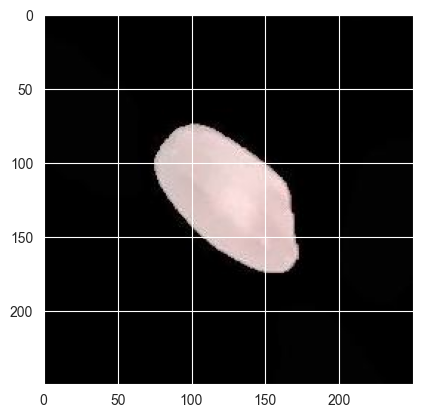

In [15]:
sample_img = cv2.imread('../Rice_Image_Dataset/Karacadag/Karacadag (600).jpg')
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

You can test by each name of photos like this: Rice_Image_Dataset/Karacadag/Karacadag (600).jpg

## 1.3 Each type of rice classes Samples

In [16]:
def load_random_img(dir,label):
    plt.figure(figsize=(10,10))
    i=0
    for label in rice_classes:
        i+=1
        plt.subplot(1,5,i)
        file=random.choice(os.listdir(f'{dir}/{label}'))
        image_path=os.path.join(f'{dir}/{label}',file)
        img=cv2.imread(image_path)
        plt.title(label)
        plt.imshow(img)
        plt.grid(None)
        plt.axis('off')

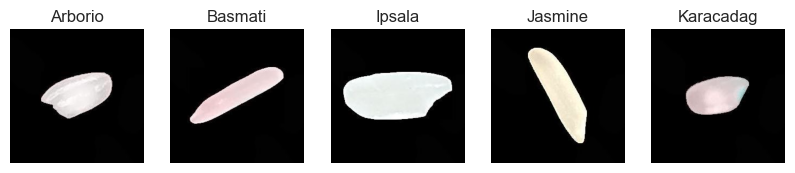

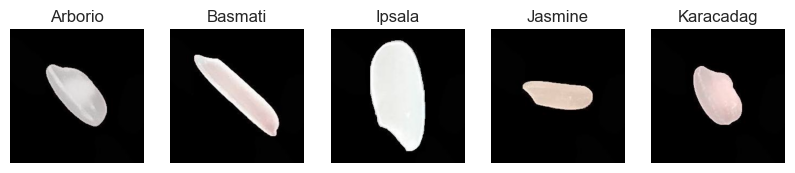

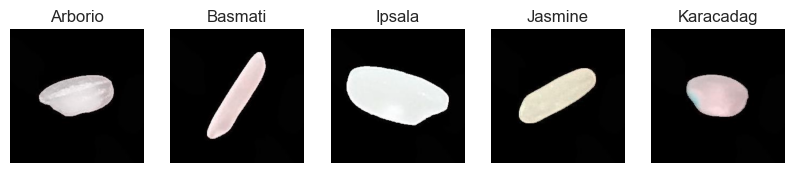

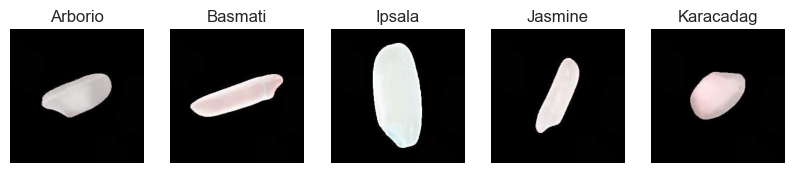

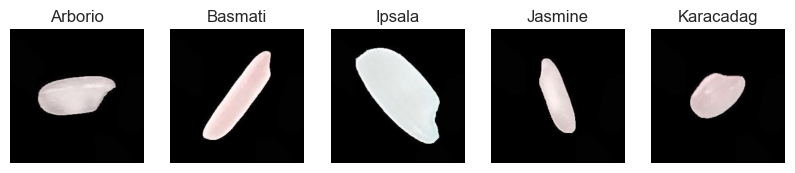

In [17]:
for i in range(5):
    load_random_img(root_path,rice_classes)

In [18]:
arborio = list(root_path.glob('Arborio/*'))[:1000]
basmati = list(root_path.glob('Basmati/*'))[:1000]
ipsala = list(root_path.glob('Ipsala/*'))[:1000]
jasmine = list(root_path.glob('Jasmine/*'))[:1000]
karacadag = list(root_path.glob('Karacadag/*'))[:1000]

In [19]:
data = {'arborio':arborio, 'basmati':basmati, 'ipsala':ipsala, 'jasmine':jasmine, 'karacadag':karacadag}

rice_labels= {0:"Arborio", 1:"Basmati", 2:"Ipsala", 3:"Jasmine", 4:"Karacadag"}

In [20]:
def load_random_img(dir, label):
    plt.figure(figsize=(10,10))
    i=0
    for label in rice_classes:
        i+=1
    plt.subplot(1, 5, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    img=cv2.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')

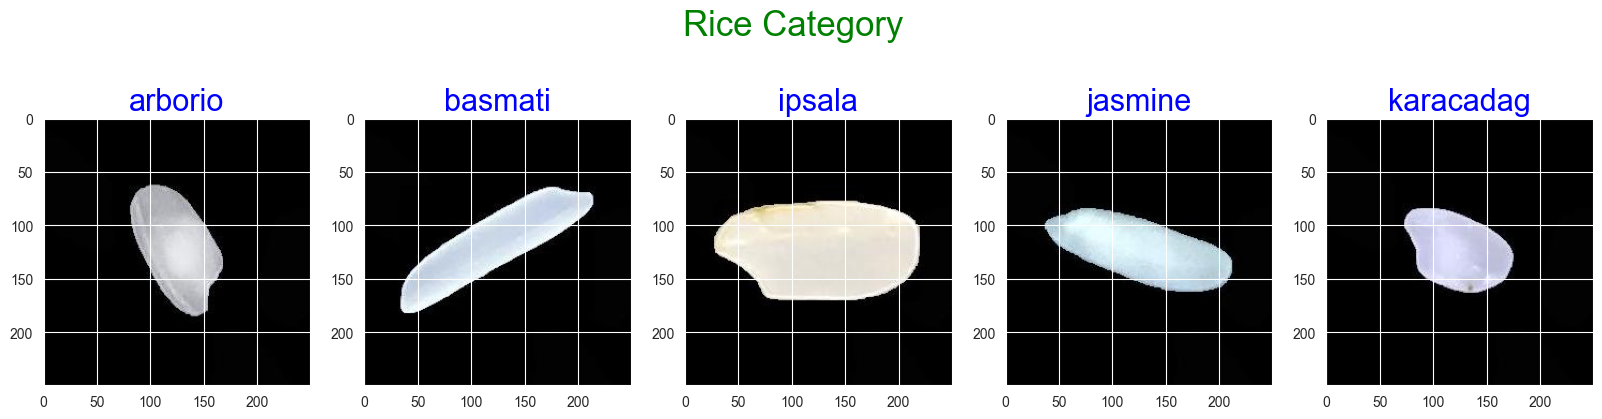

In [21]:
fig, ax = plt.subplots(ncols=5, figsize=(20,5))
fig.suptitle('Rice Category' , color='green',fontsize=25)
arborio_image = img.imread(arborio[0])
basmati_image = img.imread(basmati[0])
ipsala_image = img.imread(ipsala[0])
jasmine_image = img.imread(jasmine[0])
karacadag_image = img.imread(karacadag[0])

ax[0].set_title('arborio', fontsize=22, color='blue')
ax[1].set_title('basmati', fontsize=22, color='blue')
ax[2].set_title('ipsala', fontsize=22, color='blue')
ax[3].set_title('jasmine', fontsize=22, color='blue')
ax[4].set_title('karacadag', fontsize=22, color='blue')


ax[0].imshow(arborio_image)
ax[1].imshow(basmati_image)
ax[2].imshow(ipsala_image)
ax[3].imshow(jasmine_image)
ax[4].imshow(karacadag_image)

In [8]:
batch_size = 128
img_height, img_width = 256, 256
input_shape = (img_height, img_width, 3)

In [6]:
datagen = ImageDataGenerator(rescale=1./255)

In [9]:
Train = datagen.flow_from_directory(
    'Images/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='categorical')

Val = datagen.flow_from_directory(
    'Images/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Test = datagen.flow_from_directory(
    'Images/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Found 68155 images belonging to 5 classes.
Found 20840 images belonging to 5 classes.
Found 20855 images belonging to 5 classes.


# 2. CNN Model Training:

## 2.1 Set the parameters and process of the CNN

In [26]:
CNN = tf.keras.models.Sequential()

# Convolution
CNN.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[256,256,3]))

#Pooling
CNN.add(tf.keras.layers.MaxPool2D(pool_size=2, strides =2))

#Flattening
CNN.add(tf.keras.layers.Flatten())

#Full Conection
CNN.add(tf.keras.layers.Dense(units=512, activation='relu'))

#Output layer
CNN.add(tf.keras.layers.Dense(units=5, activation='sigmoid'))

In [27]:
CNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 516128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   264,258,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,261,509 (1008.08 MB)

 Trainable params: 264,261,509 (1008.08 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
CNN.compile(optimizer='adam', loss='binary_crossentropy' , metrics=['accuracy'])

## 2.2 Fit the model using the created traing dataset

In [29]:
Model = CNN.fit(x=Train, validation_data=Val, epochs=3)

Epoch 1/3
533/533 ━━━━━━━━━━━━━━━━━━━━ 1704s 3s/step - accuracy: 0.9219 - loss: 0.1747 - val_accuracy: 0.9933 - val_loss: 0.0099
Epoch 2/3
533/533 ━━━━━━━━━━━━━━━━━━━━ 1743s 3s/step - accuracy: 0.9938 - loss: 0.0082 - val_accuracy: 0.9937 - val_loss: 0.0085
Epoch 3/3
533/533 ━━━━━━━━━━━━━━━━━━━━ 1881s 4s/step - accuracy: 0.9959 - loss: 0.0052 - val_accuracy: 0.9959 - val_loss: 0.0057


In [30]:
CNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 516128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   264,258,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 792,784,529 (2.95 GB)

 Trainable params: 264,261,509 (1008.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 528,523,020 (1.97 GB)

## 2.3 Accuracy of CNN Model:

In [31]:
score = CNN.evaluate(Test, verbose=1)
print(f'Model Loss: {score[0]}, Accuracy: {score[1]*100}')

163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 410ms/step - accuracy: 0.9968 - loss: 0.0052
Model Loss: 0.0056006996892392635, Accuracy: 99.6116042137146


In [26]:
root_path = '../Rice_Image_Dataset'
class_names = sorted(os.listdir(root_path))
class_names

['.DS_Store',
 'Arborio',
 'Basmati',
 'Ipsala',
 'Jasmine',
 'Karacadag',
 'Rice_Citation_Request.txt']

In [27]:
del class_names[0]
del class_names[5]

print(class_names)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 401ms/step


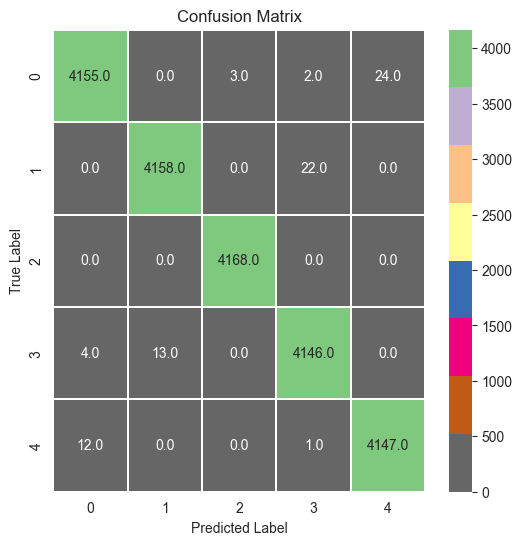

In [40]:
Y_pred = CNN.predict(Test)
y_pred = np.argmax(Y_pred, axis=1) #Max prob between 5 values
confusion_mtx = confusion_matrix(y_pred, Test.classes)
f,ax = plt.subplots(figsize=(6, 6))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax, cmap=plt.cm.Accent_r)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [18]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [42]:
report = classification_report(Test.classes, y_pred, target_names=class_names, output_dict=True)
DF_evaluation = pd.DataFrame(report).transpose()
DF_evaluation.style.apply(highlight_max)

,precision,recall,f1-score,support
Arborio,0.993069,0.996164,0.994614,4171.000000
Basmati,0.994737,0.996883,0.995809,4171.000000
Ipsala,1.000000,0.999281,0.999640,4171.000000
Jasmine,0.995916,0.994006,0.994960,4171.000000
Karacadag,0.996875,0.994246,0.995559,4171.000000
accuracy,0.996116,0.996116,0.996116,0.996116
macro avg,0.996119,0.996116,0.996116,20855.000000
weighted avg,0.996119,0.996116,0.996116,20855.000000


# 3. Random Forest Model Training

## 3.1 Set the parameters and pre-process of the Random Forest

{'Arborio': ['../Rice_Image_Dataset/Arborio/Arborio (14999).jpg'],
 'Basmati': ['../Rice_Image_Dataset/Basmati/basmati (1916).jpg'],
 'Ipsala': ['../Rice_Image_Dataset/Ipsala/Ipsala (10370).jpg'],
 'Jasmine': ['../Rice_Image_Dataset/Jasmine/Jasmine (11792).jpg'],
 'Karacadag': ['../Rice_Image_Dataset/Karacadag/Karacadag (12521).jpg']}


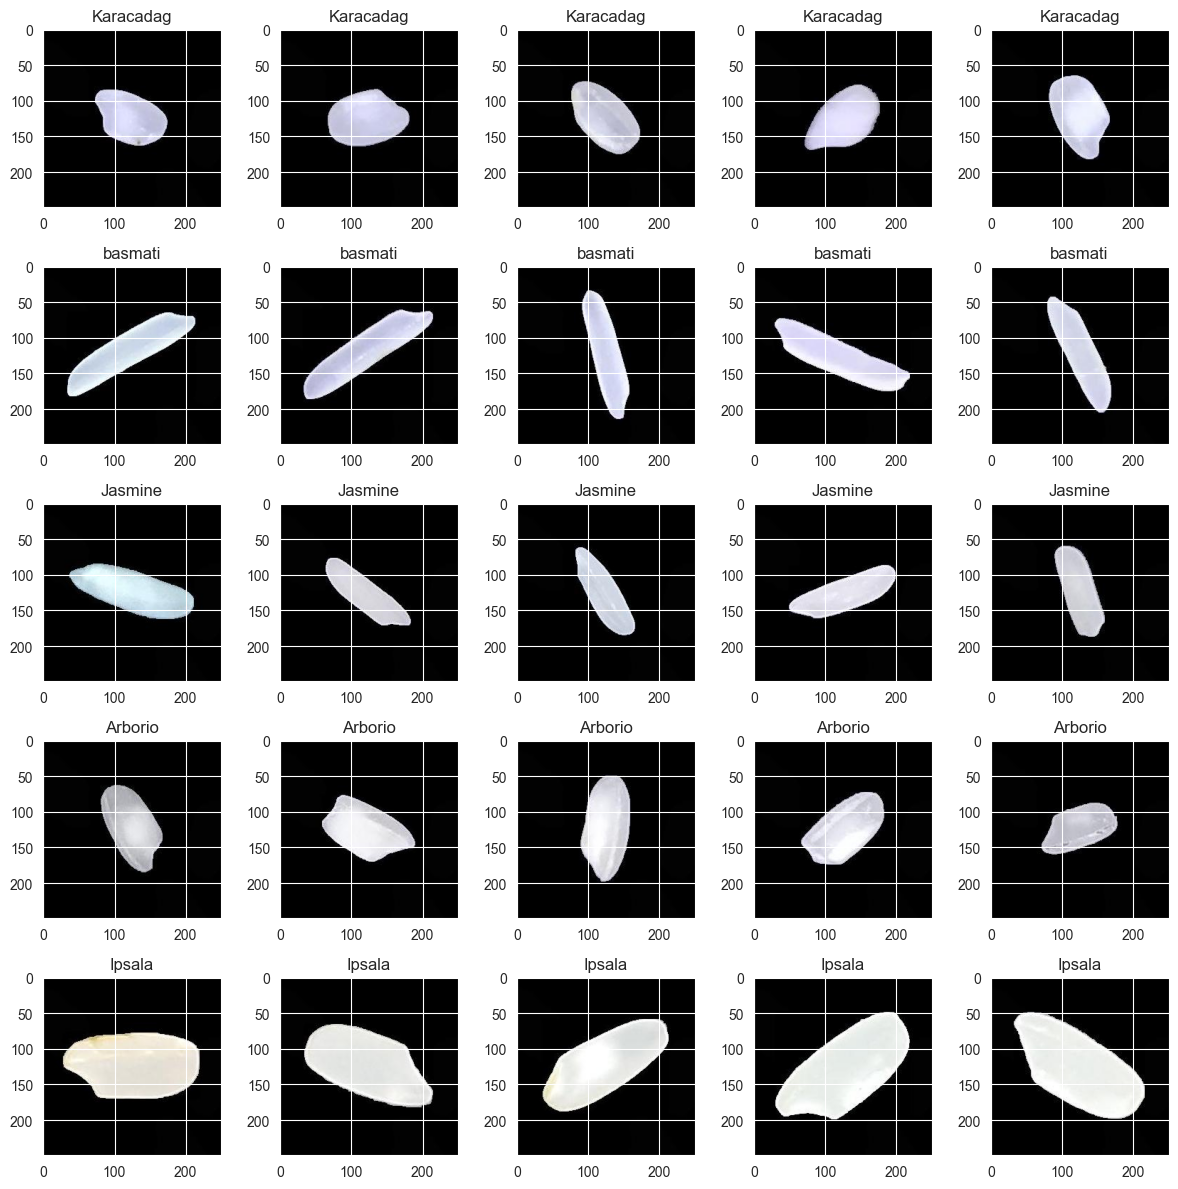

In [29]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import skimage as ski
import ipywidgets as widgets

import glob
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import pprint

NUM_CLASSES = 5
class_folders = [
    "../Rice_Image_Dataset/Karacadag",
    "../Rice_Image_Dataset/Basmati",
    "../Rice_Image_Dataset/Jasmine",
    "../Rice_Image_Dataset/Arborio",
    "../Rice_Image_Dataset/Ipsala"
]

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(12, 12))
for i, folder in enumerate(class_folders):
    for j, filename in enumerate(glob.glob(folder + "/*.jpg")[:5]):
        img = ski.io.imread(filename)
        axs[i,j].imshow(img)
        axs[i,j].set_title(filename.split("/")[-1].split()[0])
plt.tight_layout()

num_sample_images = 1
image_dict = {}
for i, folder in enumerate(class_folders):
    image_dict[folder.split("/")[-1].split()[0]] = glob.glob(folder + "/*.jpg")[:num_sample_images]

pprint.pprint(image_dict)

def to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def threshold_image(img, thresh_min=155, thresh_max=255):
    return cv2.threshold(img, thresh_min, thresh_max, cv2.THRESH_BINARY)[1]

def getContours(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return (contours, hierarchy)

def drawContours(image, contours):
    return cv2.drawContours(image, contours, -1, (255, 0, 0), 0)

def calculateImageFeatures(contours, featcols):
    feat_array = np.zeros((1, len(featcols)), np.float32)
    mmnts =  cv2.moments(contours[0], False)
    for i, k in enumerate(sorted(mmnts.keys())):
        feat_array[0, i] = mmnts[k]
    
    area = cv2.contourArea(contours[0], False)
    
    centroid_x = mmnts['m10']/(mmnts['m00'] + 0.000000000001)
    centroid_y = mmnts['m01']/(mmnts['m00'] + + 0.000000000001)
    arcLength = cv2.arcLength(contours[0], True)
    
    feat_array[0, len(mmnts)] = area
    feat_array[0, len(mmnts)+1] = centroid_x
    feat_array[0, len(mmnts)+2] = centroid_y
    feat_array[0, len(mmnts)+3] = arcLength
    
    return feat_array


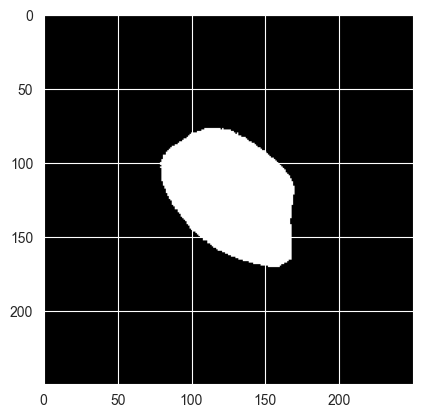

In [30]:
sample_thresh = threshold_image(to_grayscale(cv2.imread("../Rice_Image_Dataset/Karacadag/Karacadag (10000).jpg")))
plt.imshow(sample_thresh, cmap='gray')


In [31]:

cnts, h = getContours(sample_thresh)
sample_moments = cv2.moments(cnts[0], False)

feature_cols = list(sorted(sample_moments.keys())) + ["area", "centroidx", "centroidy", "length"]
pprint.pprint(feature_cols)


['m00',
 'm01',
 'm02',
 'm03',
 'm10',
 'm11',
 'm12',
 'm20',
 'm21',
 'm30',
 'mu02',
 'mu03',
 'mu11',
 'mu12',
 'mu20',
 'mu21',
 'mu30',
 'nu02',
 'nu03',
 'nu11',
 'nu12',
 'nu20',
 'nu21',
 'nu30',
 'area',
 'centroidx',
 'centroidy',
 'length']


In [32]:

sample_features = calculateImageFeatures(cnts, feature_cols)
pprint.pprint(sample_features)


array([[ 5.9530000e+03,  7.2619200e+05,  9.1690352e+07,  1.1949380e+10,
         7.5668231e+05,  9.3437808e+07,  1.1938228e+10,  9.9214184e+07,
         1.2389936e+10,  1.3375431e+10,  3.1039590e+06,  7.0072295e+06,
         1.1319734e+06,  7.3478735e+06,  3.0327352e+06, -7.3009769e+05,
        -6.6040900e+06,  8.7587915e-02,  2.5627522e-03,  3.1942170e-02,
         2.6873359e-03,  8.5578121e-02, -2.6701845e-04, -2.4153122e-03,
         5.9530000e+03,  1.2710941e+02,  1.2198757e+02,  3.0956348e+02]],
      dtype=float32)


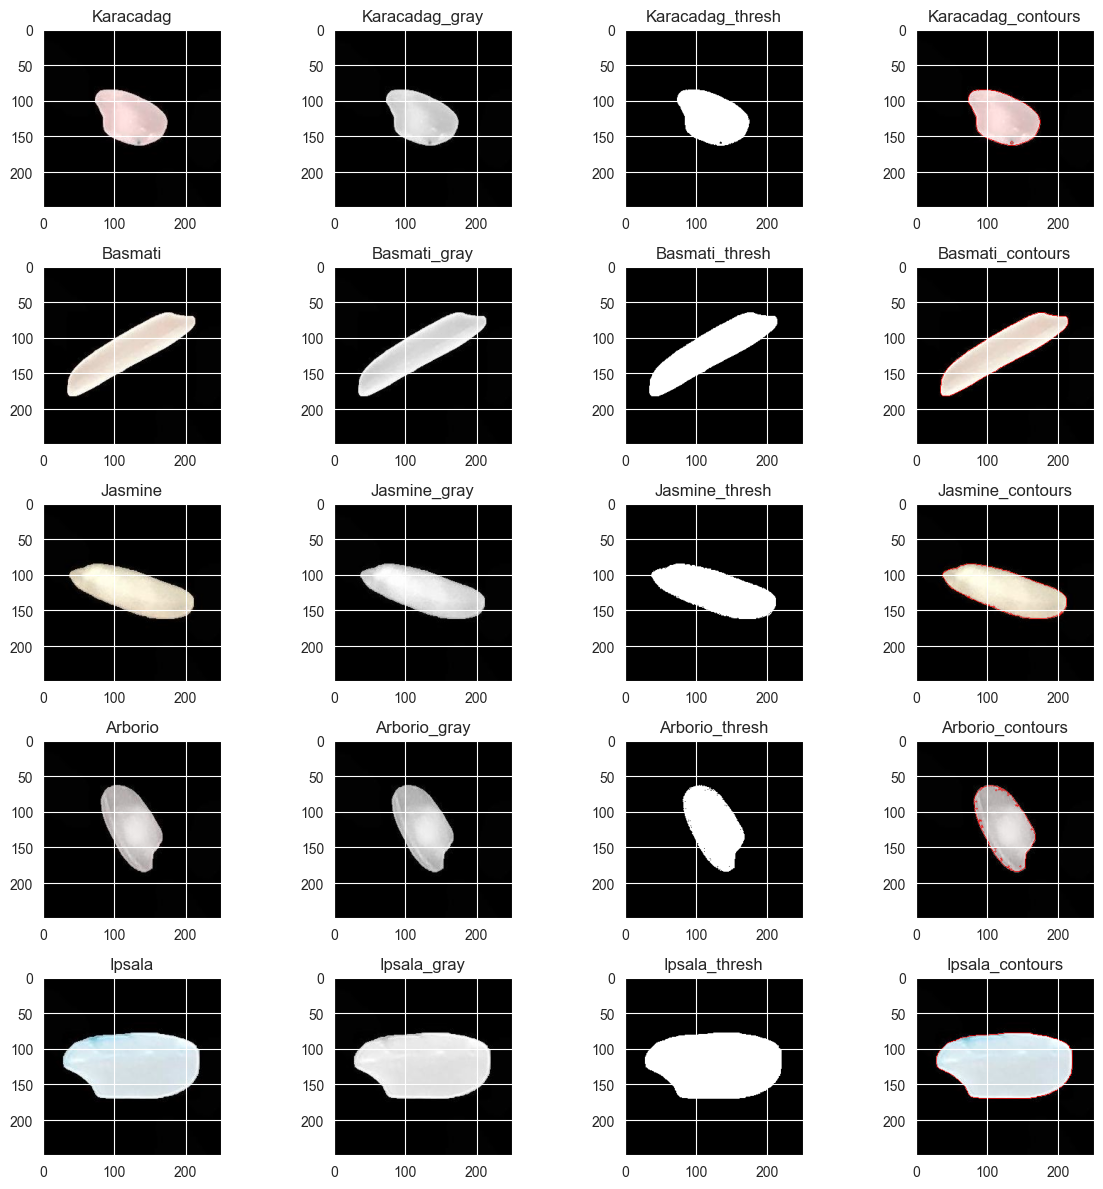

In [33]:

fig, axs = plt.subplots(nrows=5, ncols=num_sample_images*4, figsize=(12, 12))
for i, (k,v) in enumerate(image_dict.items()):
    for j, image_path in enumerate(v):
        img = cv2.imread(image_path)
        gray = to_grayscale(img)
        thresh = threshold_image(gray)
        
        cnts, h = getContours(thresh)
        withConts = drawContours(img.copy(), cnts)
        
        axs[i,j].imshow(img)
        axs[i,j].set_title(k)
        
        axs[i,j+1].imshow(gray, cmap='gray')
        axs[i,j+1].set_title(k + "_gray")
        
        axs[i,j+2].imshow(thresh, cmap='gray')
        axs[i,j+2].set_title(k + "_thresh")
        
        axs[i,j+3].imshow(withConts)
        axs[i,j+3].set_title(k + "_contours")

plt.tight_layout()
classes = list(image_dict.keys())


classwise_feature_dict = {}
classwise_img_dict = {}
error_images = []



In [34]:

for i, folder in enumerate(class_folders):
    img_class = folder.split("/")[-1].split()[0]
    array_lst = list()
    img_path_lst = list()
    
    for j, filename in enumerate(glob.glob(folder + "/*.jpg")):
        try:
            img = cv2.imread(filename)
            array_lst.append(calculateImageFeatures(getContours(threshold_image(to_grayscale(img).copy()).copy())[0], feature_cols))
            img_path_lst.append(filename)
        except Exception as err:
            error_images.append((img_class,filename))
            print(err)
            raise err
            break

    all_class_features = np.vstack(array_lst)
    classwise_feature_dict[img_class] = all_class_features
    classwise_img_dict[img_class] = img_path_lst
    print(f"Image Class: {img_class}")
    print(f"Total Images: {all_class_features.shape[0]}")
    print("--------------------------------------------")


Image Class: Karacadag
Total Images: 15000
--------------------------------------------
Image Class: Basmati
Total Images: 15000
--------------------------------------------
Image Class: Jasmine
Total Images: 15000
--------------------------------------------
Image Class: Arborio
Total Images: 15000
--------------------------------------------
Image Class: Ipsala
Total Images: 15000
--------------------------------------------


In [35]:

TOTAL_TRAIN_SAMPLES = 60000
TOTAL_TEST_SAMPLES = 15000

X_train, y_train = np.zeros((TOTAL_TRAIN_SAMPLES, len(feature_cols)), np.float32), np.zeros((TOTAL_TRAIN_SAMPLES, 1), np.float32)
X_test, y_test = np.zeros((TOTAL_TEST_SAMPLES, len(feature_cols)), np.float32), np.zeros((TOTAL_TEST_SAMPLES, 1), np.float32)
class_map = dict()

for i, (k, v) in enumerate(classwise_feature_dict.items()):
        class_map[i] = k
        X_train[i*12000:(i+1)*12000, :] = v[:12000, :]
        y_train[i*12000:(i+1)*12000, :] = i
        
        X_test[i*3000:(i+1)*3000] = v[12000:, :]
        y_test[i*3000:(i+1)*3000, :] = i

pprint.pprint(class_map)

for i in range(X_train.shape[-1]):
    ss = StandardScaler()
    ss.fit(X_train[:, i].reshape((-1, 1)))
    X_train[:, i] = ss.transform(X_train[:, i].reshape((-1, 1))).flatten()
    X_test[:, i] = ss.transform(X_test[:, i].reshape((-1, 1))).flatten()

{0: 'Karacadag', 1: 'Basmati', 2: 'Jasmine', 3: 'Arborio', 4: 'Ipsala'}


## 3.2 Fit the model using the created training dataset

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model = RandomForestClassifier(n_estimators = 100) 
model.fit(X_train, y_train.ravel())

RandomForestClassifier()

## 3.3 Accuracy of Random Forest Model

### 3.3.1 Predict & Evaluate the model

In [37]:

y_pred = model.predict(X_test)
 
print("ACCURACY OF THE MODEL: ", accuracy_score(y_test, y_pred))


ACCURACY OF THE MODEL:  0.9676666666666667


### 3.3.2 Show the confusion matrix & Total Report

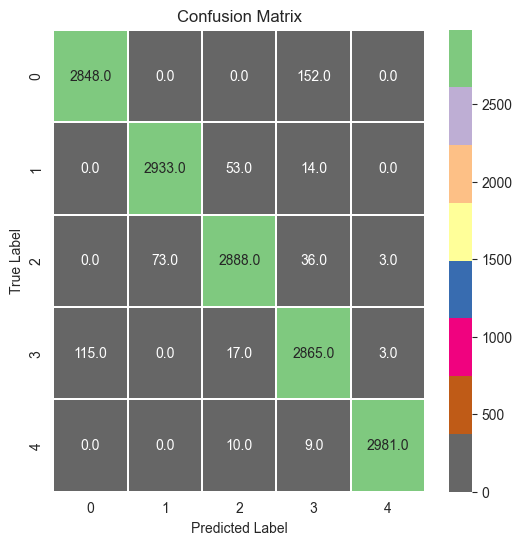

In [38]:
confusion_mtx = confusion_matrix(y_test,y_pred)
f,ax = plt.subplots(figsize=(6, 6))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax, cmap=plt.cm.Accent_r)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [39]:
report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
DF_evaluation = pd.DataFrame(report).transpose()
DF_evaluation.style.apply(highlight_max)

,precision,recall,f1-score,support
Arborio,0.961188,0.949333,0.955224,3000.000000
Basmati,0.975715,0.977667,0.976690,3000.000000
Ipsala,0.973046,0.962667,0.967828,3000.000000
Jasmine,0.931404,0.955000,0.943055,3000.000000
Karacadag,0.997991,0.993667,0.995824,3000.000000
accuracy,0.967667,0.967667,0.967667,0.967667
macro avg,0.967869,0.967667,0.967724,15000.000000
weighted avg,0.967869,0.967667,0.967724,15000.000000
